In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.io import ascii, fits
from astropy.table import Table
import lmfit
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import pandas as pd
import scipy as sp
from scipy.stats import norm
from scipy import stats

from MUSE_Models import PNe_spectrum_extractor, data_cube_y_x
%config InlineBackend.figure_format = 'retina'


In [11]:
hdulist = fits.open("FCC167_data/FCC167_emission_cube.fits")
hdr = hdulist[0].header
data = hdulist[0].data[:,100:700]
y_data, x_data, n_data = data_cube_y_x(len(data))

wavelength = np.load("FCC167_data/FCC167_wavelength.npy")
wavelength = wavelength[100:700]

#Flux_data_shape = list_of_raw_data.reshape(y_data, x_data, len(wavelength))

In [3]:
A_rN = np.load("exported_data/FCC167/A_rN_cen.npy")
gauss_A = np.load("exported_data/FCC167/gauss_A_cen.npy")
Gauss_F = np.load("exported_data/FCC167/gauss_F_cen.npy")

gauss_A_shape = gauss_A.reshape(y_data, x_data)
A_rN_shape = A_rN.reshape(y_data,x_data)
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

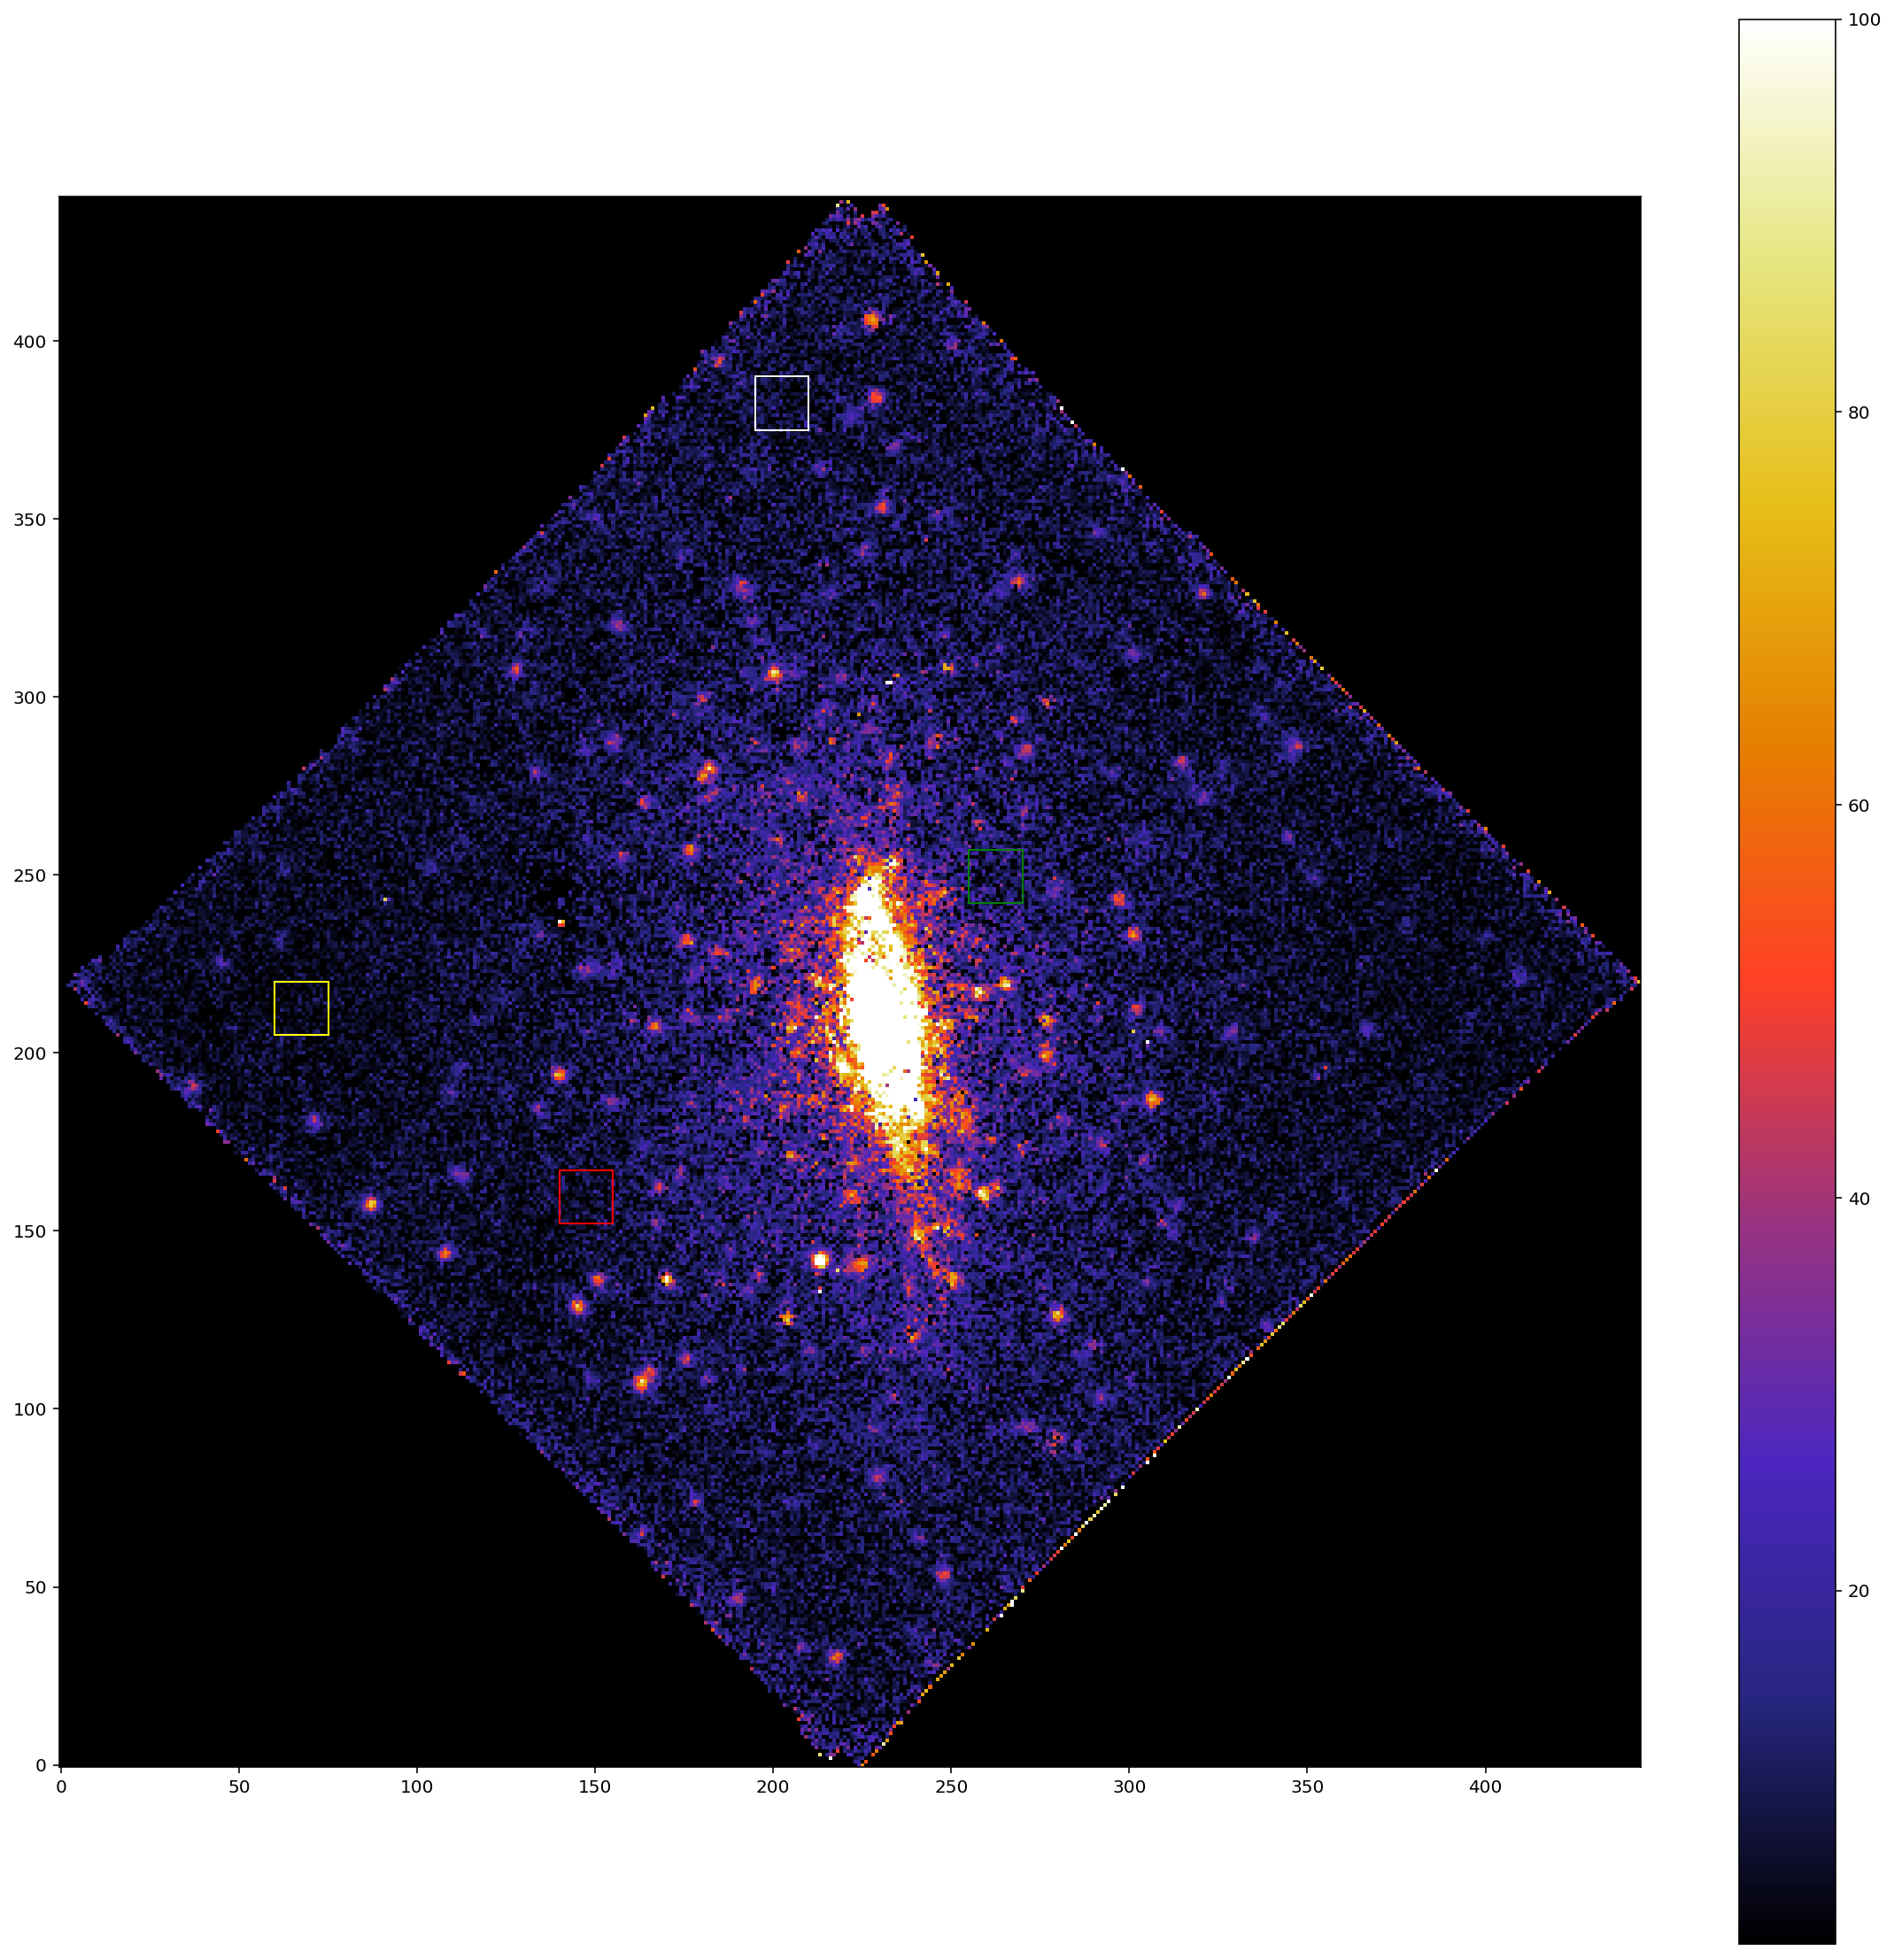

In [4]:
plt.figure(figsize=(20,20))
plt.imshow(gauss_A_shape, origin="lower", cmap="CMRmap", vmin=2, vmax=100)
plt.colorbar()
ax = plt.gca()
ax.add_patch(Rectangle((195, 375), 15, 15, fill=False, edgecolor="white"))
ax.add_patch(Rectangle((140, 152), 15, 15, fill=False, edgecolor="red"))
ax.add_patch(Rectangle((255, 242), 15, 15, fill=False, edgecolor="green"))
ax.add_patch(Rectangle((60, 205), 15, 15, fill=False, edgecolor="yellow"))
plt.draw()

# Normality testing

/local/tspriggs/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


0.29137774434716923
5.990562878521077


AndersonResult(statistic=0.7728652219315109, critical_values=array([0.572, 0.652, 0.782, 0.912, 1.085]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Ks_2sampResult(statistic=0.011522633744855959, pvalue=0.003121241151008831)

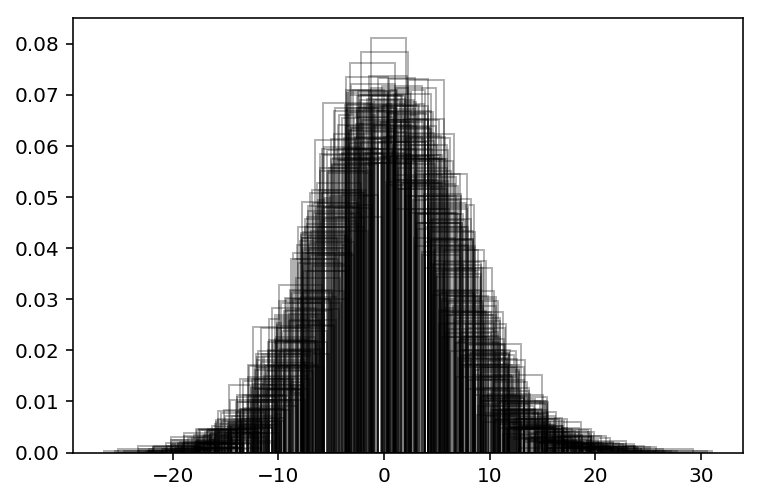

In [28]:
n_pixels=9

noise_regions = [np.array(PNe_spectrum_extractor(195, 375, n_pixels, data, x_data, wavelength)),
                 np.array(PNe_spectrum_extractor(140, 152, n_pixels, data, x_data, wavelength)),
                 np.array(PNe_spectrum_extractor(255, 242, n_pixels, data, x_data, wavelength)),
                 np.array(PNe_spectrum_extractor(60, 205, n_pixels, data, x_data, wavelength)),]

reg = 3

mu_list = np.zeros(len(noise_regions[reg]))
std_list = np.zeros(len(noise_regions[reg]))

plt.figure()
for i, spec in enumerate(noise_regions[reg]):
    plt.hist(spec, alpha=0.3,fill=False, normed=True)
    # Fit a normal distribution to the data:
    mu_list[i], std_list[i] = norm.fit(spec)
    
print(np.median(mu_list))
print(np.median(std_list))
norm_mu = np.median(mu_list)
norm_std = np.median(std_list)

display(stats.anderson(np.sum(noise_regions[reg],0), dist="norm"))

gauss_noise = np.random.normal(np.median(mu_list), np.median(std_list), (n_pixels * n_pixels, len(wavelength)))
gauss_noise_r = gauss_noise.reshape(n_pixels*n_pixels*len(wavelength))
noise_test_r = noise_regions[reg].reshape(n_pixels*n_pixels*len(wavelength))

display(stats.ks_2samp(noise_test_r,gauss_noise_r ))

In [91]:
# M_5007
Abs_M_list = np.arange(-4.5, -1.0, 0.01)
dM = 5. * np.log10(18.7) + 25
# m_5007
app_m_list = np.arange(27.0, 29.0, 0.025)#Abs_M_list + dM
# F_5007, total
total_flux_list = 10.**((app_m_list + 13.74) / -2.5)
flux = total_flux_list / 1e-20

n_pixels = 9
# make moffat profiles that equate to each total flux value
coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

def moffat(amplitude, x_0, y_0, FWHM, beta):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2. + (y_fit - y_0)**2.) / gamma**2.
    return amplitude * (1. + rr_gg)**(-beta)

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x) + (np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.))) + (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.))

n_PNe = len(app_m_list)
n_sim = 60
print("Number of PNe:", n_PNe)
print("Number of Simulations:", n_sim)
print("Total number of simulations to run:", n_PNe * n_sim)

init_FWHM = 4.0
init_beta = 2.4
#find starting amplitude
sum_init = np.sum(moffat(1., n_pixels/2., n_pixels/2., init_FWHM, init_beta))
input_moff_A = flux / sum_init

# Make moffat models = F_5007 (x,y)
Moffat_models = np.array([moffat(moff_A, n_pixels/2, n_pixels/2, init_FWHM, init_beta) for moff_A in input_moff_A])

# A_5007 (x,y)
Amp_x_y = ((Moffat_models) / (np.sqrt(2.*np.pi) * 1.19))


#for i in np.arange(0, n_sim):
#noise_cube = np.array(extractor(295, 50, n_pixels, Flux_data_shape, wavelength))


Number of PNe: 80
Number of Simulations: 60
Total number of simulations to run: 4800


In [92]:
def gen_noise(mu, std):
    noise = np.random.normal(mu, std, len(wavelength))
    return noise

# store n_sim versions of each PNe at each Abs Mag
gauss_models = np.zeros((n_PNe,n_sim,n_pixels**2,len(wavelength)))
d=10
for i in np.arange(0, n_PNe):
    for j in np.arange(0, n_sim):
        gauss_models[i,j] = np.array([gaussian(wavelength, amp, wavelength[387], 1.19, 0.0, 0.0)+ gen_noise(norm_mu, norm_std) for amp in Amp_x_y[i]]) 
        
#construct error cube
error_cube = np.zeros((n_PNe, n_sim, n_pixels**2, len(wavelength)))

for PNe_num in np.arange(0, n_PNe):
    for sim_num in np.arange(0, n_sim):
        list_of_std = [np.abs(np.std(spec)) for spec in gauss_models[PNe_num, sim_num]]
        error_cube[PNe_num, sim_num] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]


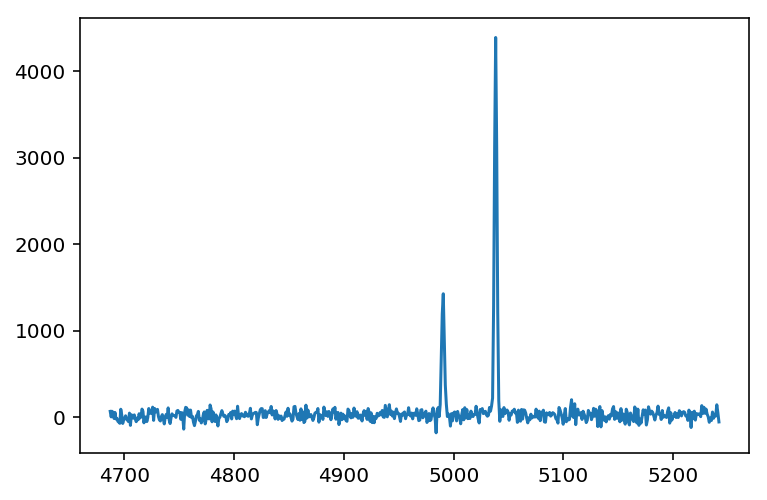

In [50]:
plt.plot(wavelength, np.sum(gauss_models[0][0],0))

In [18]:
np.save("exported_data/sim_input_fluxes", total_flux_list)

In [ ]:
# Fit 3D

list_of_A_OIII = np.zeros((n_PNe,n_sim))
list_of_resids = np.zeros((n_PNe,n_sim))
list_of_total_fitted_flux = np.zeros((n_PNe,n_sim))
list_of_fitted_flux = np.zeros((n_PNe, n_sim, n_pixels**2))

def residual(params, x, data, error, PNe_number, run):
    # List of parameters
    moffat_amp = params['moffat_amp']
    x_0 = params['x_0']
    y_0 = params['y_0']
    FWHM = params['FWHM']
    beta = params["beta"]
    mean = params["mean"]
    Gauss_std = params["Gauss_std"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]
    #Moffat model
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2. + (y_fit - y_0)**2.) / gamma**2.
    F_OIII_xy = moffat_amp * (1. + rr_gg)**(-beta)  
    # Convert Moffat flux to amplitude
    A_OIII_xy = ((F_OIII_xy) / (np.sqrt(2*np.pi) * 1.19)) 
    
    #Construct model gaussian profiles for each amplitude value in cube
    model_spectra = [(Gauss_bkg + (Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - mean)** 2 / Gauss_std**2.) +
             (Amp/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / Gauss_std**2.)) for Amp in A_OIII_xy]
    
    # Store things
    list_of_fitted_flux[PNe_num, run] = F_OIII_xy
    list_of_total_fitted_flux[PNe_num, run] = np.sum(F_OIII_xy) * 1e-20
    list_of_resids[PNe_num, run] = np.std(data - model_spectra)
    list_of_A_OIII[PNe_num, run] = np.max(A_OIII_xy)
    
    return (data - model_spectra) / error


params = Parameters()
params.add('moffat_amp', value=70., min=0.01)
params.add('x_0', value=n_pixels/2., min=0.01, max=n_pixels)
params.add('y_0', value=n_pixels/2, min=0.01, max=n_pixels)
params.add('FWHM', value=3.8, min=0.01, max=14.0, vary=True) #4.47)
params.add("beta", value=2.4, min=0.01, max=14.0, vary=True)#, vary=False) #2.39)
params.add("mean", value=5030., min=5000, max=5070)
params.add("Gauss_std", value=1.19, vary=False)
params.add("Gauss_bkg", value=0.001)
params.add("Gauss_grad", value=0.001)

list_of_M_amp = np.zeros((n_PNe,n_sim))
list_of_FWHM = np.zeros((n_PNe,n_sim))
list_of_beta = np.zeros((n_PNe,n_sim))

#f = FloatProgress(min=0, max=n_PNe*n_sim, description="Fitting progress", )
#display(f)
for PNe_num in np.arange(0, n_PNe):
    for sim_num in np.arange(0, n_sim):
        # Run the minimizer
        result = minimize(residual, params, args=(wavelength, gauss_models[PNe_num, sim_num], error_cube[PNe_num, sim_num], PNe_num, sim_num))
        list_of_M_amp[PNe_num, sim_num] = result.params["moffat_amp"]
        list_of_FWHM[PNe_num, sim_num] = result.params["FWHM"]
        list_of_beta[PNe_num, sim_num] = result.params["beta"]
#        f.value+=1.



In [ ]:
#A / rN
A_by_rN = list_of_A_OIII / list_of_resids
##
###save outputs
#np.save("exported_data/input_moff_A", input_moff_A)
#np.save("exported_data/output_moff_A", list_of_M_amp)
#np.save("exported_data/output_FWHM", list_of_FWHM)
#np.save("exported_data/output_beta", list_of_beta)
#np.save("exported_data/A_by_rN", A_by_rN)
#np.save("exported_data/total_F", list_of_total_fitted_flux)
#
# read in saved files
#input_moff_A = np.load("exported_data/input_moff_A.npy")
#list_of_M_amp = np.load("exported_data/output_moff_A.npy")
#list_of_FWHM = np.load("exported_data/output_FWHM.npy")
#list_of_beta = np.load("exported_data/output_beta.npy")
#A_by_rN = np.load("exported_data/A_by_rN.npy")
#list_of_total_fitted_flux = np.load("exported_data/total_F.npy")

In [88]:
np.max(A_by_rN)

33.48261064879936

In [ ]:
# Calculate Deltas

m_5007_out = -2.5 * np.log10(list_of_total_fitted_flux) - 13.74

#M_5007_out = m_5007_out - dM

n_PNe = len(A_by_rN)
n_sim = len(A_by_rN[0])

# create plots and delta params, out minus in
delta_moff_amp = np.zeros((n_PNe,n_sim))
for pne in np.arange(0, n_PNe):
    for sim in np.arange(0, n_sim):
        #delta_moff_amp[pne, sim] = input_moff_A[pne] - list_of_M_amp[pne, sim]
        delta_moff_amp[pne, sim] = ((input_moff_A[pne] - list_of_M_amp[pne, sim])/input_moff_A[pne])*100

delta_total_F = np.zeros((n_PNe,n_sim))
for pne in np.arange(0, n_PNe):
    for sim in np.arange(0, n_sim):
        #delta_total_F[pne, sim] =  (flux[pne]) - (list_of_total_fitted_flux[pne, sim]/1e-20)
        delta_total_F[pne, sim] =  ((flux[pne] - (list_of_total_fitted_flux[pne, sim]/1e-20))/flux[pne])*100
        
delta_m_5007 = np.zeros((n_PNe,n_sim))
for pne in np.arange(0, n_PNe):
    for sim in np.arange(0, n_sim):
        #delta_m_5007[pne, sim] = app_m_list[pne] - m_5007_out[pne, sim]
        delta_m_5007[pne, sim] = ((app_m_list[pne] - m_5007_out[pne, sim])/app_m_list[pne])*100
        
        
#delta_FWHM = init_FWHM - list_of_FWHM
delta_FWHM = ((init_FWHM - list_of_FWHM)/init_FWHM)*100
#delta_beta = init_beta - list_of_beta
delta_beta = ((init_beta - list_of_beta) / init_beta)*100

In [ ]:
plt.figure(1, figsize=(18,14))

ax0 = plt.subplot(2,2,1)
plt.scatter(A_by_rN, delta_total_F)
plt.xlabel("A/rN", fontsize=18)
plt.ylabel("Delta $F_{5007}$", fontsize=18)
plt.axhline(y=0, c="k", ls="dashed")
plt.axvline(x=2, c="k", ls="dashed")
#ax0.annotate("Under estimated", xy=(1,1), xytext=(17.5,500))
#ax0.annotate("Over estimated", xy=(1,1), xytext=(17.5,-500))
#plt.axhline(y=250, c="k", ls="dotted")
#plt.axhline(y=-250, c="k", ls="dotted")
plt.ylim(-100,100)

ax1 = plt.subplot(2,2,2)
plt.scatter(A_by_rN, delta_m_5007)
plt.xlabel("A/rN", fontsize=18)
plt.ylabel("Delta $m_{5007}$", fontsize=18)
plt.axhline(y=0, c="k", ls="dashed")
plt.axvline(x=2, c="k", ls="dashed")
#plt.axhline(10, c="k", ls="dashed")
#plt.axhline(-10, c="k", ls="dashed")
#ax1.annotate("Under estimated", xy=(5,1), xytext=(16,0.3))
#ax1.annotate("Over estimated", xy=(5,1), xytext=(16,-0.3))
#plt.ylim(-5,5)
plt.ylim(-100,100)

ax2 = plt.subplot(2,2,3)
plt.scatter(A_by_rN, delta_FWHM)
plt.xlabel("A/rN", fontsize=18)
plt.ylabel("Delta FWHM", fontsize=18)
plt.axhline(y=0, c="k", ls="dashed")
plt.axvline(x=2, c="k", ls="dashed")
#plt.axhline(10, c="k", ls="dashed")
#plt.axhline(-10,c="k", ls="dashed")
#ax2.annotate("Under estimated", xy=(5,1), xytext=(16,1))
#ax2.annotate("Over estimated", xy=(5,1), xytext=(16,-1))
#plt.ylim(-0.1,0.1)
plt.ylim(-100,100)

ax3 = plt.subplot(2,2,4)
plt.scatter(A_by_rN, delta_beta)
plt.xlabel("A/rN", fontsize=18)
plt.ylabel("Delta Beta", fontsize=18)
plt.axhline(y=0, c="k", ls="dashed")
plt.axvline(x=2, c="k", ls="dashed")
#ax3.annotate("Under estimated", xy=(5,1), xytext=(16,2))
#ax3.annotate("Over estimated", xy=(5,1), xytext=(16,-2))
#plt.ylim(-4,4)
plt.axhline(y=15, c="k", ls="dotted")
plt.axhline(y=-15, c="k", ls="dotted")
plt.ylim(-100,100)

#plt.savefig("Plots/simulations/PSF_sim_fitting_PSF.png")

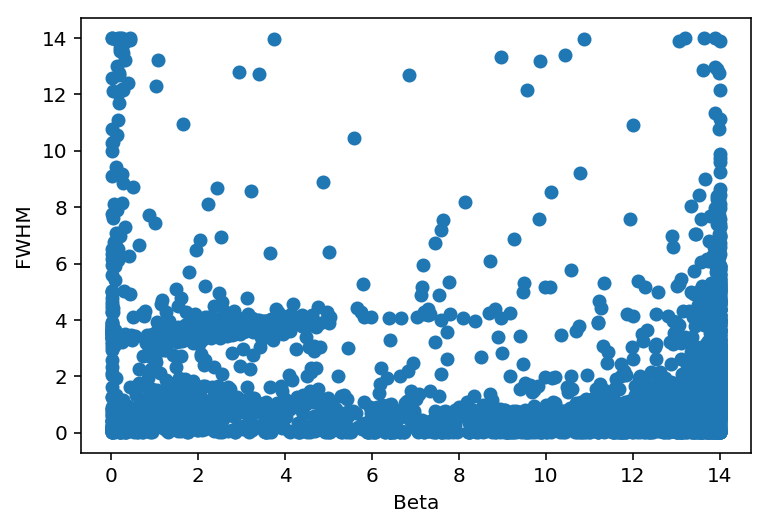

In [81]:
plt.scatter(list_of_beta, list_of_FWHM)
plt.xlabel("Beta")
plt.ylabel("FWHM")
plt.show()

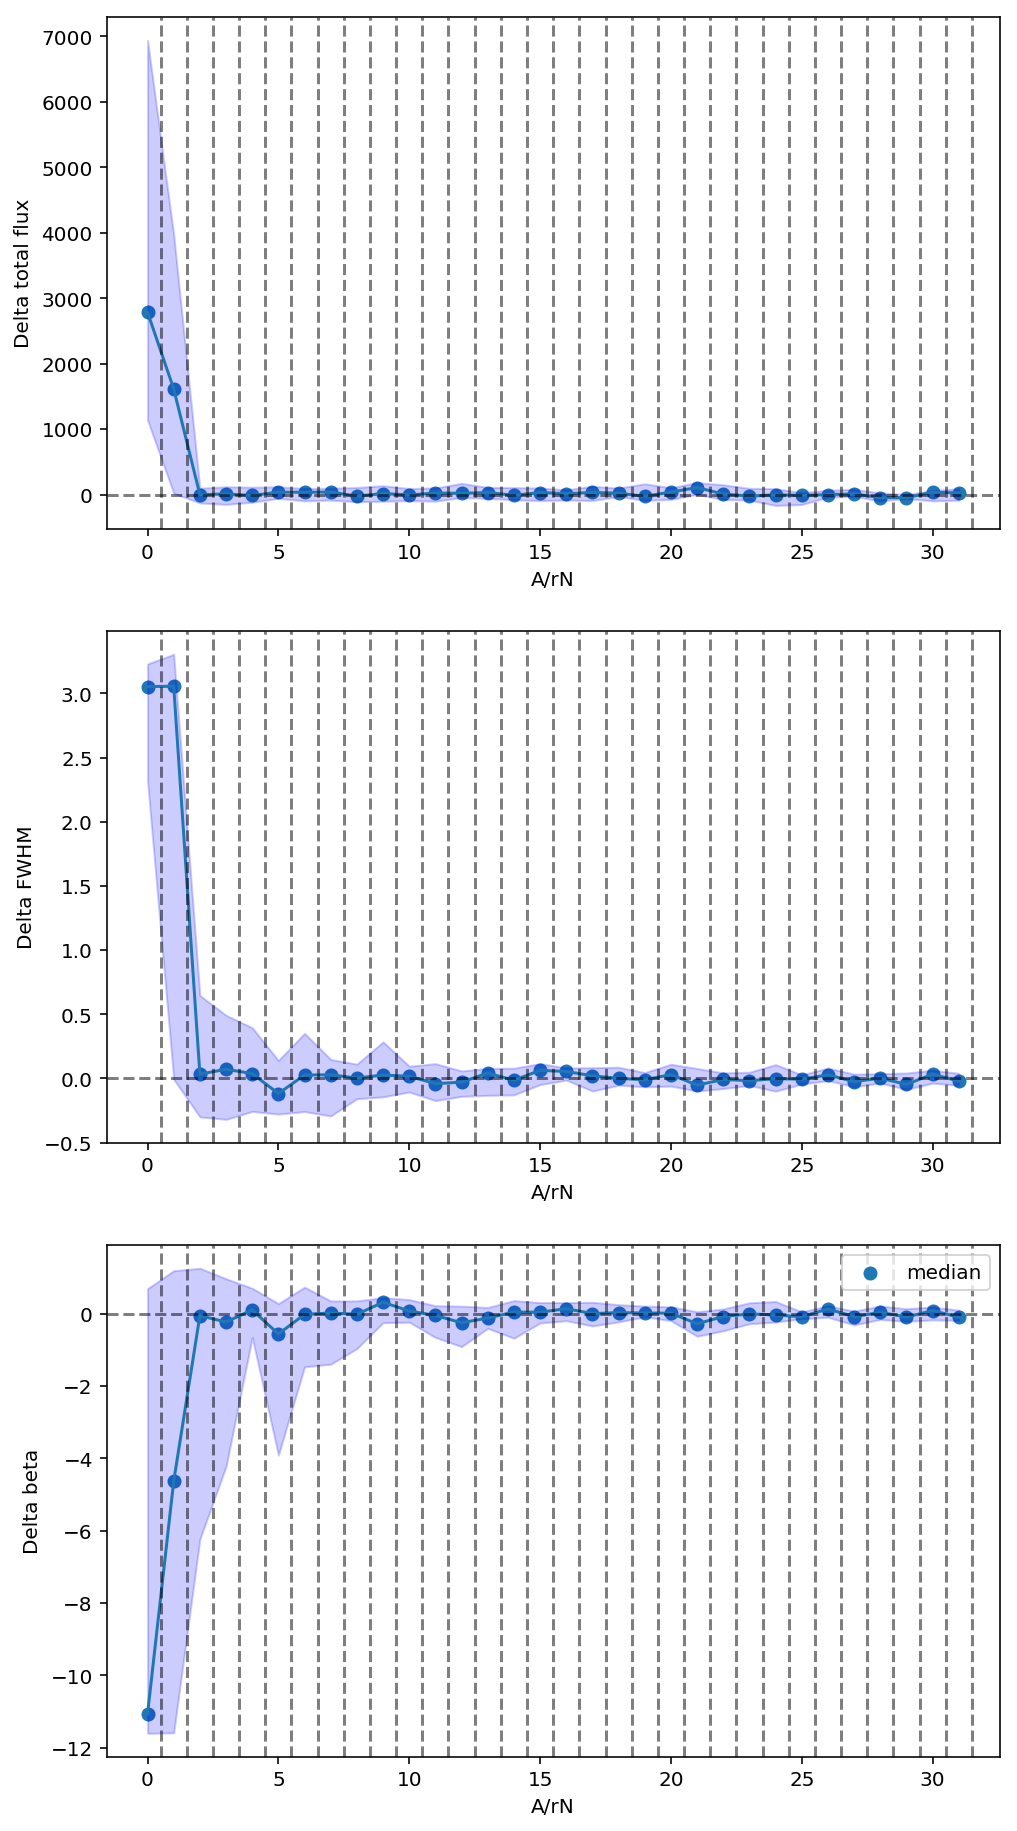

In [69]:
n_bins = np.arange(1,np.ceil(np.max(A_by_rN)))
digitized = np.digitize(A_by_rN, n_bins)

def mean_16_84(data):
    binned_data_mean = [np.percentile(data[digitized == i], 50) for i in range(1, len(n_bins))]
    binned_data_16 = [np.percentile(data[digitized == i], 16) for i in range(1, len(n_bins))]
    binned_data_84 = [np.percentile(data[digitized == i], 84) for i in range(1, len(n_bins))]
    
    return binned_data_mean, binned_data_16, binned_data_84

binned_F, binned_F_16, binned_F_84 = mean_16_84(delta_total_F)
binned_FWHM, binned_FWHM_16, binned_FWHM_84 = mean_16_84(delta_FWHM)
binned_beta, binned_beta_16, binned_beta_84 = mean_16_84(delta_beta)

plt.figure(2, figsize=(8,16))

# FLUX
plt.subplot(3,1,1)
plt.scatter(np.arange(0,len(binned_F)), binned_F, label="median")
plt.plot(np.arange(0,len(binned_F)), binned_F)
plt.fill_between(np.arange(0,len(binned_F)), binned_F_16, binned_F_84, color="blue", alpha=0.2, linestyle="None")
plt.axhline(y=0, c="k", ls="dashed", alpha=0.5)
for j in np.arange(0.5,int(len(binned_F)+0.5)):
    plt.axvline(x=j,c="k",  ls="dashed", alpha=0.5)
plt.xlabel("A/rN")
plt.ylabel("Delta total flux") 

# FWHM
plt.subplot(3,1,2)
plt.scatter(np.arange(0,float(len(binned_FWHM))), binned_FWHM, label="median")
plt.plot(np.arange(0,float(len(binned_FWHM))), binned_FWHM)
plt.fill_between(np.arange(0,float(len(binned_FWHM))), binned_FWHM_16, binned_FWHM_84, color="blue", alpha=0.2, linestyle="None")
plt.axhline(y=0, c="k", ls="dashed", alpha=0.5)
for j in np.arange(0.5,int(len(binned_FWHM)+0.5)):
    plt.axvline(x=j,c="k",  ls="dashed", alpha=0.5)
plt.xlabel("A/rN")
plt.ylabel("Delta FWHM")
#plt.ylim(-5,5)

# BETA
plt.subplot(3,1,3)
plt.scatter(np.arange(0, len(binned_beta)), binned_beta, label="median")
plt.plot(np.arange(0, len(binned_beta)), binned_beta)
plt.fill_between(np.arange(0,len(binned_beta)), binned_beta_16, binned_beta_84, color="blue", alpha=0.2, linestyle="None")
plt.axhline(y=0, c="k", ls="dashed", alpha=0.5)
for j in np.arange(0.5, int(len(binned_beta)+0.5)):
    plt.axvline(x=j,c="k",  ls="dashed", alpha=0.5)
plt.xlabel("A/rN")
plt.ylabel("Delta beta")
#plt.ylim(-5,10)
plt.legend(loc=1)

#plt.savefig("Plots/PSF_sim_binned_median_results.png")